# Graph Structure Validation and Ablation Studies for GNN Electoral Forecasting

## Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from scipy.spatial.distance import cdist
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create output directories
os.makedirs('results', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("All packages imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"NetworkX version: {nx.__version__}")

c:\Users\Ayoub\anaconda3\envs\gnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All packages imported successfully
PyTorch version: 2.9.1+cu130
NumPy version: 1.26.4
NetworkX version: 3.1


## Helper Functions: Data Generation with CAR Process

In [ ]:
def generate_geography(n_districts=120, precincts_per_district=12.5, domain_size=10):
    """
    Generate synthetic precinct locations and cluster into districts.
    
    Parameters:
    - n_districts: Number of congressional districts
    - precincts_per_district: Average precincts per district
    - domain_size: Spatial domain is [0, domain_size] x [0, domain_size]
    
    Returns:
    - precinct_locs: (n_precincts, 2) array of (x, y) coordinates
    - district_assignments: (n_precincts,) array of district IDs
    - district_centroids: (n_districts, 2) array of district centers
    """
    n_precincts = int(n_districts * precincts_per_district)
    
    # Generate random precinct locations
    precinct_locs = np.random.uniform(0, domain_size, size=(n_precincts, 2))
    
    # Cluster into districts using k-means
    kmeans = KMeans(n_clusters=n_districts, random_state=42, n_init=10)
    district_assignments = kmeans.fit_predict(precinct_locs)
    district_centroids = kmeans.cluster_centers_
    
    return precinct_locs, district_assignments, district_centroids


def create_spatial_adjacency(centroids, method='contiguity', k_neighbors=5, threshold=2.0):
    """
    Create adjacency matrix based on spatial relationships.
    
    Parameters:
    - centroids: (n_districts, 2) array of district centers
    - method: 'contiguity' (k-NN) or 'distance_threshold'
    - k_neighbors: Number of neighbors for k-NN method
    - threshold: Distance threshold for threshold method
    
    Returns:
    - adjacency: (n_districts, n_districts) binary adjacency matrix
    """
    n = len(centroids)
    adjacency = np.zeros((n, n))
    
    if method == 'contiguity':
        # k-nearest neighbors (symmetric)
        nbrs = NearestNeighbors(n_neighbors=k_neighbors+1).fit(centroids)
        distances, indices = nbrs.kneighbors(centroids)
        
        for i in range(n):
            for j in indices[i, 1:]:  # Skip self (first neighbor)
                adjacency[i, j] = 1
                adjacency[j, i] = 1  # Make symmetric
    
    elif method == 'distance_threshold':
        # Distance threshold
        distances = cdist(centroids, centroids)
        adjacency = (distances < threshold).astype(int)
        np.fill_diagonal(adjacency, 0)  # No self-loops
    
    return adjacency


def generate_features(n_precincts, n_features=5, spatial_smooth=True, 
                     precinct_locs=None, sigma_spatial=2.0):
    """
    Generate precinct-level features with optional spatial smoothing.
    
    Features: Income, Education, Density, Age, Diversity
    """
    # Initialize from standard normal
    X = np.random.randn(n_precincts, n_features)
    
    if spatial_smooth and precinct_locs is not None:
        # Spatial smoothing via inverse distance weighting
        distances = cdist(precinct_locs, precinct_locs)
        weights = np.exp(-distances / sigma_spatial)
        np.fill_diagonal(weights, 0)
        weights = weights / weights.sum(axis=1, keepdims=True)
        
        # 3 iterations of smoothing
        for _ in range(3):
            X = 0.7 * X + 0.3 * (weights @ X)
    
    # Induce realistic correlations
    # Income-Education: +0.7 correlation
    X[:, 1] = 0.7 * X[:, 0] + 0.3 * X[:, 1]
    # Density-Age: -0.4 correlation
    X[:, 3] = -0.4 * X[:, 2] + 0.6 * X[:, 3]
    
    return X


def aggregate_to_districts(precinct_features, district_assignments):
    """
    Aggregate precinct-level features to district level by averaging.
    """
    n_districts = district_assignments.max() + 1
    n_features = precinct_features.shape[1]
    district_features = np.zeros((n_districts, n_features))
    
    for d in range(n_districts):
        mask = (district_assignments == d)
        district_features[d] = precinct_features[mask].mean(axis=0)
    
    return district_features


def generate_outcomes_CAR(X, adjacency, rho=0.65, beta=None, sigma2=0.08):
    """
    Generate electoral outcomes using Conditional Autoregressive (CAR) model.
    
    y = (I - rho*W)^{-1} (X*beta + epsilon)
    
    Parameters:
    - X: (n_districts, n_features) feature matrix
    - adjacency: (n_districts, n_districts) adjacency matrix
    - rho: Spatial autocorrelation parameter [0, 1)
    - beta: Feature coefficients (default: [0.10, 0.08, -0.05, 0.03, -0.07])
    - sigma2: Noise variance
    
    Returns:
    - y: (n_districts,) electoral outcomes in [0, 1]
    """
    n = X.shape[0]
    
    if beta is None:
        beta = np.array([0.10, 0.08, -0.05, 0.03, -0.07])
    
    # Row-normalize adjacency to get W
    W = adjacency.copy().astype(float)
    row_sums = W.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    W = W / row_sums[:, np.newaxis]
    
    # Deterministic component
    mu = X @ beta
    
    # Random component
    epsilon = np.random.randn(n) * np.sqrt(sigma2)
    
    # CAR model: y = (I - rho*W)^{-1} (mu + epsilon)
    I = np.eye(n)
    y_raw = np.linalg.solve(I - rho * W, mu + epsilon)
    
    # Transform to [0, 1] vote shares
    y_norm = (y_raw - y_raw.min()) / (y_raw.max() - y_raw.min())
    y_final = 0.35 + (y_norm - 0.5) * 0.5  # Center around 0.35-0.65
    y_final = np.clip(y_final, 0.05, 0.95)
    
    return y_final


print("Data generation functions defined")

✅ Data generation functions defined


## Helper Functions: Graph Manipulation

In [ ]:
def rewire_graph(adjacency, rewiring_fraction=0.1, preserve_degree=True):
    """
    Rewire a fraction of edges in a graph.
    
    Parameters:
    - adjacency: (n, n) binary adjacency matrix
    - rewiring_fraction: Fraction of edges to rewire (0 to 1)
    - preserve_degree: If True, preserve degree distribution (Maslov-Sneppen algorithm)
    
    Returns:
    - rewired_adjacency: New adjacency matrix with rewired edges
    """
    # Convert to NetworkX graph
    G = nx.from_numpy_array(adjacency)
    n_edges = G.number_of_edges()
    n_rewire = int(n_edges * rewiring_fraction)
    
    if preserve_degree:
        # Maslov-Sneppen rewiring: swap edge endpoints
        edges = list(G.edges())
        for _ in range(n_rewire * 2):  # More attempts for success
            if len(edges) < 2:
                break
            
            idx1, idx2 = np.random.choice(len(edges), size=2, replace=False)
            (a, b) = edges[idx1]
            (c, d) = edges[idx2]
            
            # Try to swap: (a,b) and (c,d) -> (a,d) and (c,b)
            if (not G.has_edge(a, d)) and (not G.has_edge(c, b)) and \
               (a != d) and (c != b) and (a != c) and (b != d):
                G.remove_edge(a, b)
                G.remove_edge(c, d)
                G.add_edge(a, d)
                G.add_edge(c, b)
                edges[idx1] = (a, d)
                edges[idx2] = (c, b)
    else:
        # Simple rewiring: remove random edges, add random edges
        edges_to_remove = np.random.choice(list(G.edges()), size=n_rewire, replace=False)
        G.remove_edges_from(edges_to_remove)
        
        # Add random edges
        n = G.number_of_nodes()
        for _ in range(n_rewire):
            i, j = np.random.choice(n, size=2, replace=False)
            if not G.has_edge(i, j):
                G.add_edge(i, j)
    
    # Convert back to adjacency matrix
    rewired_adjacency = nx.to_numpy_array(G).astype(int)
    return rewired_adjacency


def create_random_graph(n_nodes, edge_density):
    """
    Create Erdős-Rényi random graph with specified edge density.
    
    Parameters:
    - n_nodes: Number of nodes
    - edge_density: Probability p = 2*m / (n*(n-1)) where m is number of edges
    
    Returns:
    - adjacency: (n, n) binary adjacency matrix
    """
    G = nx.erdos_renyi_graph(n_nodes, edge_density, seed=42)
    adjacency = nx.to_numpy_array(G).astype(int)
    return adjacency


def compute_edge_density(adjacency):
    """
    Compute edge density: 2*m / (n*(n-1)) for undirected graph.
    """
    n = len(adjacency)
    m = adjacency.sum() / 2  # Divide by 2 for undirected
    density = 2 * m / (n * (n - 1)) if n > 1 else 0
    return density


def create_distance_weighted_graph(centroids, k_neighbors=5):
    """
    Create graph with edge weights as inverse distances.
    
    Returns:
    - edge_index: (2, num_edges) COO format
    - edge_weight: (num_edges,) inverse distance weights
    """
    n = len(centroids)
    
    # Find k nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k_neighbors+1).fit(centroids)
    distances, indices = nbrs.kneighbors(centroids)
    
    edge_list = []
    weight_list = []
    
    for i in range(n):
        for j_idx, j in enumerate(indices[i, 1:]):  # Skip self
            dist = distances[i, j_idx + 1]
            weight = np.exp(-dist / 2.0)  # Inverse exponential distance
            edge_list.append([i, j])
            edge_list.append([j, i])  # Symmetric
            weight_list.append(weight)
            weight_list.append(weight)
    
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(weight_list, dtype=torch.float)
    
    return edge_index, edge_weight


def create_distance_features(X, centroids, k_neighbors=5):
    """
    Augment features with distance-based neighborhood statistics.
    
    For each district, compute mean, std, min, max of k nearest neighbors' features.
    
    Parameters:
    - X: (n, d) original features
    - centroids: (n, 2) district locations
    - k_neighbors: Number of neighbors to use
    
    Returns:
    - X_augmented: (n, d + 4*d) features with neighborhood stats
    """
    n, d = X.shape
    
    # Find k nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k_neighbors+1).fit(centroids)
    distances, indices = nbrs.kneighbors(centroids)
    
    # Compute neighborhood statistics
    neighbor_mean = np.zeros((n, d))
    neighbor_std = np.zeros((n, d))
    neighbor_min = np.zeros((n, d))
    neighbor_max = np.zeros((n, d))
    
    for i in range(n):
        neighbor_indices = indices[i, 1:]  # Exclude self
        neighbor_features = X[neighbor_indices]
        
        neighbor_mean[i] = neighbor_features.mean(axis=0)
        neighbor_std[i] = neighbor_features.std(axis=0)
        neighbor_min[i] = neighbor_features.min(axis=0)
        neighbor_max[i] = neighbor_features.max(axis=0)
    
    # Concatenate all features
    X_augmented = np.hstack([X, neighbor_mean, neighbor_std, neighbor_min, neighbor_max])
    
    return X_augmented


print("Graph manipulation functions defined")

✅ Graph manipulation functions defined


## GNN Model Architectures (EXACT MATCH TO SIMULATION STUDY)

In [ ]:
class SimpleGCN(nn.Module):
    """
    Graph Convolutional Network.
    EXACT architecture from simulation_study_9_comprehensive_scenarios.ipynb
    """
    def __init__(self, n_features, hidden_dims=[32, 16, 8], dropout=0.1):
        super().__init__()
        self.conv1 = GCNConv(n_features, hidden_dims[0])
        self.conv2 = GCNConv(hidden_dims[0], hidden_dims[1])
        self.conv3 = GCNConv(hidden_dims[1], hidden_dims[2])
        self.fc = nn.Linear(hidden_dims[2], 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight=None):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index, edge_weight))
        return torch.sigmoid(self.fc(x)).squeeze()


class GraphAttentionNet(nn.Module):
    """
    Graph Attention Network.
    EXACT architecture from simulation_study_9_comprehensive_scenarios.ipynb
    Note: heads=4 for first two layers, heads=1 for last layer
    """
    def __init__(self, n_features, hidden_dims=[32, 16, 8], heads=4, dropout=0.1):
        super().__init__()
        self.conv1 = GATConv(n_features, hidden_dims[0], heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dims[0] * heads, hidden_dims[1], heads=heads, dropout=dropout)
        self.conv3 = GATConv(hidden_dims[1] * heads, hidden_dims[2], heads=1, dropout=dropout)  # heads=1 for last layer
        self.fc = nn.Linear(hidden_dims[2], 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight=None, return_attention=False):
        if return_attention:
            x, attn1 = self.conv1(x, edge_index, return_attention_weights=True)
            x = F.elu(x)
            x = self.dropout(x)
            
            x, attn2 = self.conv2(x, edge_index, return_attention_weights=True)
            x = F.elu(x)
            x = self.dropout(x)
            
            x, attn3 = self.conv3(x, edge_index, return_attention_weights=True)
            x = F.elu(x)
            
            out = torch.sigmoid(self.fc(x)).squeeze()
            return out, (attn1, attn2, attn3)
        else:
            x = F.elu(self.conv1(x, edge_index))
            x = self.dropout(x)
            x = F.elu(self.conv2(x, edge_index))
            x = self.dropout(x)
            x = F.elu(self.conv3(x, edge_index))
            return torch.sigmoid(self.fc(x)).squeeze()


class DenseNN(nn.Module):
    """
    Baseline Dense Neural Network.
    EXACT architecture from simulation_study_9_comprehensive_scenarios.ipynb
    """
    def __init__(self, n_features, hidden_dims=[64, 32, 16], dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(n_features, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        return torch.sigmoid(self.fc4(x)).squeeze()


print("Model architectures defined (GCN, GAT, Dense)")
print("   - SimpleGCN: hidden_dims=[32, 16, 8]")
print("   - GraphAttentionNet: hidden_dims=[32, 16, 8], heads=4→4→1")
print("   - DenseNN: hidden_dims=[64, 32, 16]")

✅ Model architectures defined (GCN, GAT, Dense)
   - SimpleGCN: hidden_dims=[32, 16, 8]
   - GraphAttentionNet: hidden_dims=[32, 16, 8], heads=4→4→1
   - DenseNN: hidden_dims=[64, 32, 16]


## Training and Evaluation Functions

In [ ]:
def train_gnn_model(model, data, epochs=150, lr=0.005, verbose=False):
    """
    Train a GNN model.
    
    Parameters:
    - model: PyTorch model (GCN or GAT)
    - data: PyG Data object with x, edge_index, y
    - epochs: Number of training epochs
    - lr: Learning rate
    
    Returns:
    - trained model
    - training losses
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    criterion = nn.MSELoss()
    
    model.train()
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        if hasattr(data, 'edge_weight'):
            out = model(data.x, data.edge_index, data.edge_weight)
        else:
            out = model(data.x, data.edge_index)
        
        loss = criterion(out, data.y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        losses.append(loss.item())
        
        if verbose and (epoch + 1) % 30 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
    
    return model, losses


def train_dense_model(model, X, y, epochs=150, lr=0.005, verbose=False):
    """
    Train a dense neural network.
    """
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    criterion = nn.MSELoss()
    
    model.train()
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(X_tensor)
        loss = criterion(out, y_tensor)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())
        
        if verbose and (epoch + 1) % 30 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
    
    return model, losses


def evaluate_model(y_true, y_pred):
    """
    Compute evaluation metrics.
    
    Returns:
    - dict with MAE, RMSE, R²
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}


print("Training and evaluation functions defined")

✅ Training and evaluation functions defined


---
# EXPERIMENT 1: Graph Rewiring Ablation


In [ ]:
print("="*80)
print("EXPERIMENT 1: Graph Rewiring Ablation Study")
print("="*80)

# Parameters
n_districts = 120
n_replications = 100
rho = 0.65  # Moderate spatial autocorrelation

# Storage for results
exp1_results = []

print(f"\nRunning {n_replications} replications with n={n_districts} districts, rho={rho}...\n")

for rep in range(n_replications):
    if (rep + 1) % 10 == 0:
        print(f"Replication {rep+1}/{n_replications}...")
    
    # Generate data
    precinct_locs, district_assignments, centroids = generate_geography(
        n_districts=n_districts, precincts_per_district=12.5
    )
    
    precinct_features = generate_features(
        len(precinct_locs), n_features=5, spatial_smooth=True, 
        precinct_locs=precinct_locs
    )
    
    X = aggregate_to_districts(precinct_features, district_assignments)
    
    # True spatial adjacency
    adj_true = create_spatial_adjacency(centroids, method='contiguity', k_neighbors=5)
    y = generate_outcomes_CAR(X, adj_true, rho=rho)
    
    # Create 4 graph variants
    adj_10_rewire = rewire_graph(adj_true, rewiring_fraction=0.1, preserve_degree=True)
    adj_30_rewire = rewire_graph(adj_true, rewiring_fraction=0.3, preserve_degree=True)
    edge_density = compute_edge_density(adj_true)
    adj_random = create_random_graph(n_districts, edge_density)
    
    # Convert to PyG format
    def adj_to_edge_index(adj):
        edge_list = np.argwhere(adj > 0)
        return torch.tensor(edge_list.T, dtype=torch.long)
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    
    # Test each graph variant
    for graph_type, adj in [
        ('True Spatial', adj_true),
        ('10% Rewiring', adj_10_rewire),
        ('30% Rewiring', adj_30_rewire),
        ('Random', adj_random)
    ]:
        edge_index = adj_to_edge_index(adj)
        data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor)
        
        # Train GCN (using EXACT model from simulation study)
        model = SimpleGCN(n_features=5, hidden_dims=[32, 16, 8])
        model, _ = train_gnn_model(model, data, epochs=100, lr=0.005)
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            y_pred = model(data.x, data.edge_index).numpy()
        
        metrics = evaluate_model(y, y_pred)
        
        exp1_results.append({
            'replication': rep + 1,
            'graph_type': graph_type,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'R2': metrics['R2']
        })

# Convert to DataFrame
df_exp1 = pd.DataFrame(exp1_results)

# Save results
df_exp1.to_csv('results/experiment1_graph_rewiring.csv', index=False)
print("\n Results saved to 'results/experiment1_graph_rewiring.csv'")

# Summary statistics
print("\n" + "="*80)
print("EXPERIMENT 1 RESULTS SUMMARY")
print("="*80)

summary = df_exp1.groupby('graph_type')['MAE'].agg(['mean', 'std']).round(4)
summary = summary.reindex(['True Spatial', '10% Rewiring', '30% Rewiring', 'Random'])
print("\nMAE by Graph Type:")
print(summary)

# Statistical tests
print("\nStatistical Significance Tests (Paired t-tests):")
true_spatial_mae = df_exp1[df_exp1['graph_type'] == 'True Spatial']['MAE'].values

for graph_type in ['10% Rewiring', '30% Rewiring', 'Random']:
    variant_mae = df_exp1[df_exp1['graph_type'] == graph_type]['MAE'].values
    t_stat, p_value = stats.ttest_rel(true_spatial_mae, variant_mae)
    pct_increase = ((variant_mae.mean() - true_spatial_mae.mean()) / true_spatial_mae.mean()) * 100
    print(f"  {graph_type:20s}: +{pct_increase:5.1f}% increase, p={p_value:.6f}")

print("\n Experiment 1 complete!")

EXPERIMENT 1: Graph Rewiring Ablation Study

Running 100 replications with n=120 districts, rho=0.65...

Replication 10/100...
Replication 20/100...
Replication 30/100...
Replication 40/100...
Replication 50/100...
Replication 60/100...
Replication 70/100...
Replication 80/100...
Replication 90/100...
Replication 100/100...

✅ Results saved to 'results/experiment1_graph_rewiring.csv'

EXPERIMENT 1 RESULTS SUMMARY

MAE by Graph Type:
                mean     std
graph_type                  
True Spatial  0.0729  0.0086
10% Rewiring  0.0756  0.0084
30% Rewiring  0.0771  0.0086
Random        0.0778  0.0085

Statistical Significance Tests (Paired t-tests):
  10% Rewiring        : +  3.8% increase, p=0.000000
  30% Rewiring        : +  5.8% increase, p=0.000000
  Random              : +  6.8% increase, p=0.000000

✅ Experiment 1 complete!


✅ Plot saved to 'plots/experiment1_graph_rewiring.png'


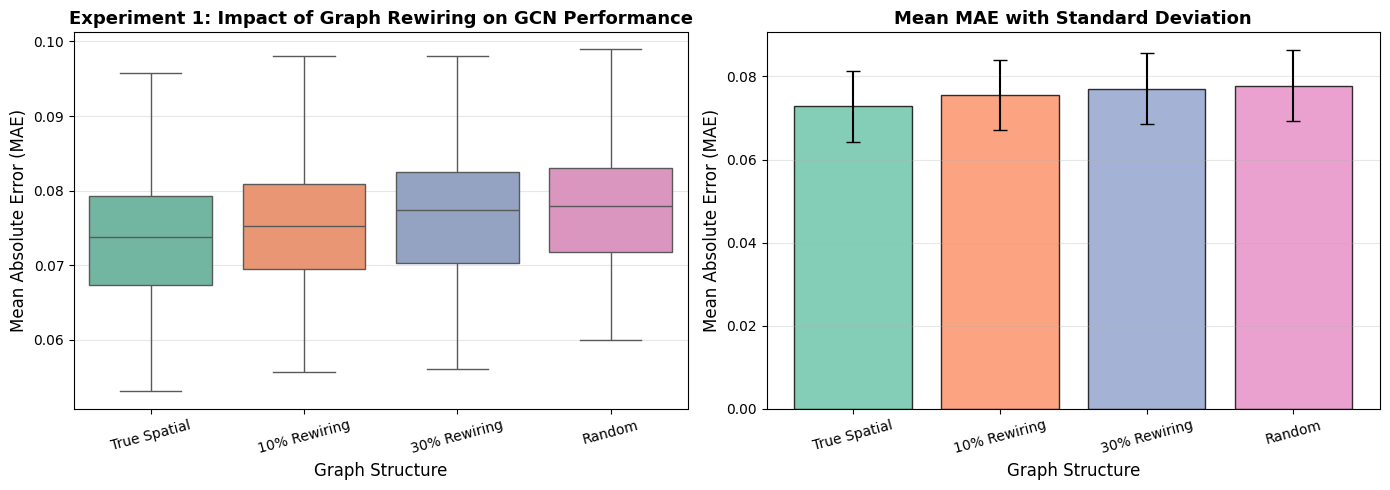

In [ ]:
# Visualize Experiment 1 results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Boxplot of MAE by graph type
graph_order = ['True Spatial', '10% Rewiring', '30% Rewiring', 'Random']
df_exp1['graph_type'] = pd.Categorical(df_exp1['graph_type'], categories=graph_order, ordered=True)

sns.boxplot(data=df_exp1, x='graph_type', y='MAE', ax=axes[0], palette='Set2')
axes[0].set_xlabel('Graph Structure', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
axes[0].set_title('Experiment 1: Impact of Graph Rewiring on GCN Performance', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Bar plot with error bars
summary_plot = df_exp1.groupby('graph_type')['MAE'].agg(['mean', 'std']).reset_index()
summary_plot['graph_type'] = pd.Categorical(summary_plot['graph_type'], categories=graph_order, ordered=True)
summary_plot = summary_plot.sort_values('graph_type')

x_pos = np.arange(len(summary_plot))
axes[1].bar(x_pos, summary_plot['mean'], yerr=summary_plot['std'], 
            capsize=5, color=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], 
            edgecolor='black', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(summary_plot['graph_type'], rotation=15)
axes[1].set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
axes[1].set_xlabel('Graph Structure', fontsize=12)
axes[1].set_title('Mean MAE with Standard Deviation', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/experiment1_graph_rewiring.png', dpi=300, bbox_inches='tight')
print("Plot saved to 'plots/experiment1_graph_rewiring.png'")
plt.show()

---
# EXPERIMENT 2: Graph vs. Distance-Only Features

In [ ]:
print("="*80)
print("EXPERIMENT 2: Graph Structure vs. Distance-Only Features")
print("="*80)

# Parameters
n_districts = 120
n_replications = 50  # Fewer reps since this is more computationally intensive
rho = 0.65

exp2_results = []

print(f"\nRunning {n_replications} replications with n={n_districts} districts, rho={rho}...\n")

for rep in range(n_replications):
    if (rep + 1) % 5 == 0:
        print(f"Replication {rep+1}/{n_replications}...")
    
    # Generate data
    precinct_locs, district_assignments, centroids = generate_geography(
        n_districts=n_districts, precincts_per_district=12.5
    )
    
    precinct_features = generate_features(
        len(precinct_locs), n_features=5, spatial_smooth=True, 
        precinct_locs=precinct_locs
    )
    
    X = aggregate_to_districts(precinct_features, district_assignments)
    adj_spatial = create_spatial_adjacency(centroids, method='contiguity', k_neighbors=5)
    y = generate_outcomes_CAR(X, adj_spatial, rho=rho)
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    
    # Configuration 1: GNN + Spatial Graph
    edge_index_spatial = torch.tensor(np.argwhere(adj_spatial > 0).T, dtype=torch.long)
    data_spatial = Data(x=X_tensor, edge_index=edge_index_spatial, y=y_tensor)
    
    model_gcn = SimpleGCN(n_features=5, hidden_dims=[32, 16, 8])
    model_gcn, _ = train_gnn_model(model_gcn, data_spatial, epochs=100, lr=0.005)
    
    model_gcn.eval()
    with torch.no_grad():
        y_pred_gcn_spatial = model_gcn(data_spatial.x, data_spatial.edge_index).numpy()
    
    metrics = evaluate_model(y, y_pred_gcn_spatial)
    exp2_results.append({
        'replication': rep + 1,
        'configuration': 'GNN + Spatial Graph',
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'R2': metrics['R2']
    })
    
    # Configuration 2: GNN + Distance Graph
    edge_index_dist, edge_weight_dist = create_distance_weighted_graph(centroids, k_neighbors=5)
    data_distance = Data(x=X_tensor, edge_index=edge_index_dist, 
                        edge_weight=edge_weight_dist, y=y_tensor)
    
    model_gcn_dist = SimpleGCN(n_features=5, hidden_dims=[32, 16, 8])
    model_gcn_dist, _ = train_gnn_model(model_gcn_dist, data_distance, epochs=100, lr=0.005)
    
    model_gcn_dist.eval()
    with torch.no_grad():
        y_pred_gcn_dist = model_gcn_dist(data_distance.x, data_distance.edge_index, 
                                         data_distance.edge_weight).numpy()
    
    metrics = evaluate_model(y, y_pred_gcn_dist)
    exp2_results.append({
        'replication': rep + 1,
        'configuration': 'GNN + Distance Graph',
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'R2': metrics['R2']
    })
    
    # Configuration 3: Dense NN + Distance Features
    X_dist_features = create_distance_features(X, centroids, k_neighbors=5)
    
    model_dense_dist = DenseNN(n_features=X_dist_features.shape[1], hidden_dims=[64, 32, 16])
    model_dense_dist, _ = train_dense_model(model_dense_dist, X_dist_features, y, 
                                            epochs=100, lr=0.005)
    
    model_dense_dist.eval()
    with torch.no_grad():
        y_pred_dense_dist = model_dense_dist(torch.FloatTensor(X_dist_features)).numpy()
    
    metrics = evaluate_model(y, y_pred_dense_dist)
    exp2_results.append({
        'replication': rep + 1,
        'configuration': 'Dense NN + Distance Features',
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'R2': metrics['R2']
    })
    
    # Configuration 4: Dense NN Baseline
    model_dense = DenseNN(n_features=5, hidden_dims=[64, 32, 16])
    model_dense, _ = train_dense_model(model_dense, X, y, epochs=100, lr=0.005)
    
    model_dense.eval()
    with torch.no_grad():
        y_pred_dense = model_dense(X_tensor).numpy()
    
    metrics = evaluate_model(y, y_pred_dense)
    exp2_results.append({
        'replication': rep + 1,
        'configuration': 'Dense NN Baseline',
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'R2': metrics['R2']
    })

# Save results
df_exp2 = pd.DataFrame(exp2_results)
df_exp2.to_csv('results/experiment2_graph_vs_distance.csv', index=False)
print("\n Results saved to 'results/experiment2_graph_vs_distance.csv'")

# Summary
print("\n" + "="*80)
print("EXPERIMENT 2 RESULTS SUMMARY")
print("="*80)

summary_exp2 = df_exp2.groupby('configuration').agg({'MAE': ['mean', 'std'],
                                                      'RMSE': ['mean', 'std'],
                                                      'R2': ['mean', 'std']}).round(4)
config_order = ['GNN + Spatial Graph', 'GNN + Distance Graph', 
                'Dense NN + Distance Features', 'Dense NN Baseline']
summary_exp2 = summary_exp2.reindex(config_order)
print("\nPerformance by Configuration:")
print(summary_exp2)

# Compute improvement percentages
baseline_mae = df_exp2[df_exp2['configuration'] == 'Dense NN Baseline']['MAE'].mean()
print("\nImprovement vs. Dense NN Baseline:")
for config in config_order[:-1]:
    config_mae = df_exp2[df_exp2['configuration'] == config]['MAE'].mean()
    improvement = ((baseline_mae - config_mae) / baseline_mae) * 100
    print(f"  {config:35s}: {improvement:5.1f}% improvement")

print("\n Experiment 2 complete!")

EXPERIMENT 2: Graph Structure vs. Distance-Only Features

Running 50 replications with n=120 districts, rho=0.65...

Replication 5/50...
Replication 10/50...
Replication 15/50...
Replication 20/50...
Replication 25/50...
Replication 30/50...
Replication 35/50...
Replication 40/50...
Replication 45/50...
Replication 50/50...

✅ Results saved to 'results/experiment2_graph_vs_distance.csv'

EXPERIMENT 2 RESULTS SUMMARY

Performance by Configuration:
                                 MAE            RMSE              R2        
                                mean     std    mean     std    mean     std
configuration                                                               
GNN + Spatial Graph           0.0732  0.0074  0.0916  0.0081  0.1187  0.0918
GNN + Distance Graph          0.0728  0.0079  0.0910  0.0086  0.1296  0.1006
Dense NN + Distance Features  0.0601  0.0077  0.0761  0.0091  0.3823  0.1348
Dense NN Baseline             0.0735  0.0065  0.0919  0.0073  0.1161  0.0431

Improveme

✅ Plot saved to 'plots/experiment2_graph_vs_distance.png'


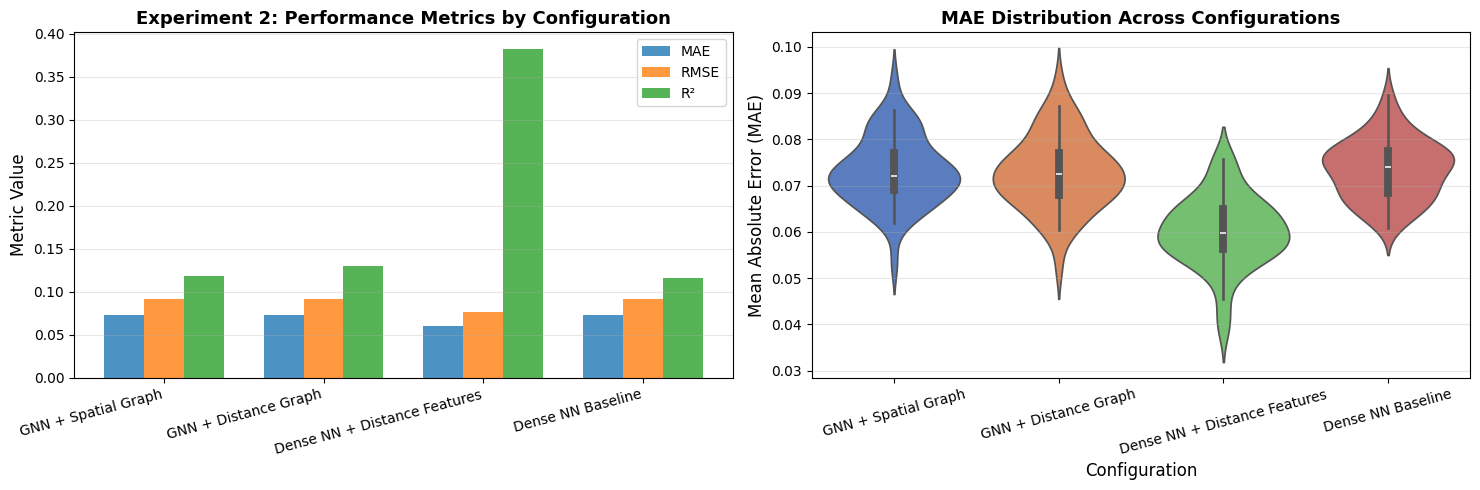

In [ ]:
# Visualize Experiment 2 results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ensure ordering
config_order = ['GNN + Spatial Graph', 'GNN + Distance Graph', 
                'Dense NN + Distance Features', 'Dense NN Baseline']
df_exp2['configuration'] = pd.Categorical(df_exp2['configuration'], 
                                          categories=config_order, ordered=True)

# Plot 1: Grouped bar chart for all metrics
summary_melted = df_exp2.groupby('configuration')[['MAE', 'RMSE', 'R2']].mean().reset_index()
summary_melted = summary_melted.sort_values('configuration')

x_pos = np.arange(len(summary_melted))
width = 0.25

axes[0].bar(x_pos - width, summary_melted['MAE'], width, label='MAE', alpha=0.8)
axes[0].bar(x_pos, summary_melted['RMSE'], width, label='RMSE', alpha=0.8)
axes[0].bar(x_pos + width, summary_melted['R2'], width, label='R²', alpha=0.8)

axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(summary_melted['configuration'], rotation=15, ha='right')
axes[0].set_ylabel('Metric Value', fontsize=12)
axes[0].set_title('Experiment 2: Performance Metrics by Configuration', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: MAE comparison with statistical annotations
sns.violinplot(data=df_exp2, x='configuration', y='MAE', ax=axes[1], palette='muted')
axes[1].set_xlabel('Configuration', fontsize=12)
axes[1].set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
axes[1].set_title('MAE Distribution Across Configurations', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/experiment2_graph_vs_distance.png', dpi=300, bbox_inches='tight')
print(" Plot saved to 'plots/experiment2_graph_vs_distance.png'")
plt.show()

---
# EXPERIMENT 3a: Synthetic Non-Stationary Data Generation


In [ ]:
def generate_nonstationary_outcomes(X, adjacency, centroids, rho_by_quadrant, 
                                   domain_size=10, beta=None, sigma2=0.08):
    """
    Generate outcomes with spatially varying autocorrelation.
    
    Parameters:
    - rho_by_quadrant: dict mapping quadrant index to rho value
      {0: rho_NW, 1: rho_NE, 2: rho_SW, 3: rho_SE}
    """
    n = len(centroids)
    
    if beta is None:
        beta = np.array([0.10, 0.08, -0.05, 0.03, -0.07])
    
    # Assign districts to quadrants based on centroid location
    mid_x, mid_y = domain_size / 2, domain_size / 2
    quadrants = np.zeros(n, dtype=int)
    
    for i, (x, y) in enumerate(centroids):
        if x < mid_x and y >= mid_y:
            quadrants[i] = 0  # NW
        elif x >= mid_x and y >= mid_y:
            quadrants[i] = 1  # NE
        elif x < mid_x and y < mid_y:
            quadrants[i] = 2  # SW
        else:
            quadrants[i] = 3  # SE
    
    # Generate outcomes separately for each quadrant, then combine
    y_combined = np.zeros(n)
    
    for q in range(4):
        mask = (quadrants == q)
        n_q = mask.sum()
        
        if n_q == 0:
            continue
        
        # Extract subgraph for this quadrant
        indices = np.where(mask)[0]
        X_q = X[mask]
        
        # Create within-quadrant adjacency
        adj_q = np.zeros((n_q, n_q))
        idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(indices)}
        
        for i_old in indices:
            for j_old in indices:
                if adjacency[i_old, j_old] > 0:
                    i_new = idx_map[i_old]
                    j_new = idx_map[j_old]
                    adj_q[i_new, j_new] = 1
        
        # Generate CAR outcomes for this quadrant
        rho_q = rho_by_quadrant[q]
        y_q = generate_outcomes_CAR(X_q, adj_q, rho=rho_q, beta=beta, sigma2=sigma2)
        
        y_combined[mask] = y_q
    
    return y_combined, quadrants


print("Non-stationary data generation function defined")

✅ Non-stationary data generation function defined


In [ ]:
print("="*80)
print("EXPERIMENT 3a: Synthetic Non-Stationary Data")
print("="*80)

# Parameters
n_districts = 120
n_replications = 50
rho_by_quadrant = {0: 0.8, 1: 0.4, 2: 0.6, 3: 0.3}  # NW, NE, SW, SE

exp3a_results = []

print(f"\nSpatial autocorrelation by quadrant:")
print(f"  NW (top-left): ρ = {rho_by_quadrant[0]} (strong)")
print(f"  NE (top-right): ρ = {rho_by_quadrant[1]} (weak)")
print(f"  SW (bottom-left): ρ = {rho_by_quadrant[2]} (moderate)")
print(f"  SE (bottom-right): ρ = {rho_by_quadrant[3]} (very weak)")
print(f"\nRunning {n_replications} replications...\n")

for rep in range(n_replications):
    if (rep + 1) % 5 == 0:
        print(f"Replication {rep+1}/{n_replications}...")
    
    # Generate data
    precinct_locs, district_assignments, centroids = generate_geography(
        n_districts=n_districts, precincts_per_district=12.5
    )
    
    precinct_features = generate_features(
        len(precinct_locs), n_features=5, spatial_smooth=True, 
        precinct_locs=precinct_locs
    )
    
    X = aggregate_to_districts(precinct_features, district_assignments)
    adj = create_spatial_adjacency(centroids, method='contiguity', k_neighbors=5)
    
    # Generate non-stationary outcomes
    y, quadrants = generate_nonstationary_outcomes(X, adj, centroids, rho_by_quadrant)
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    edge_index = torch.tensor(np.argwhere(adj > 0).T, dtype=torch.long)
    data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor)
    
    # Model 1: GAT (with attention) - EXACT simulation study architecture
    model_gat = GraphAttentionNet(n_features=5, hidden_dims=[32, 16, 8], heads=4)
    model_gat, _ = train_gnn_model(model_gat, data, epochs=100, lr=0.003)
    
    model_gat.eval()
    with torch.no_grad():
        y_pred_gat = model_gat(data.x, data.edge_index).numpy()
    
    metrics = evaluate_model(y, y_pred_gat)
    exp3a_results.append({
        'replication': rep + 1,
        'model': 'GAT (Attention)',
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'R2': metrics['R2']
    })
    
    # Model 2: GCN (standard) - EXACT simulation study architecture
    model_gcn = SimpleGCN(n_features=5, hidden_dims=[32, 16, 8])
    model_gcn, _ = train_gnn_model(model_gcn, data, epochs=100, lr=0.005)
    
    model_gcn.eval()
    with torch.no_grad():
        y_pred_gcn = model_gcn(data.x, data.edge_index).numpy()
    
    metrics = evaluate_model(y, y_pred_gcn)
    exp3a_results.append({
        'replication': rep + 1,
        'model': 'GCN (Standard)',
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'R2': metrics['R2']
    })
    
    # Model 3: Dense NN - EXACT simulation study architecture
    model_dense = DenseNN(n_features=5, hidden_dims=[64, 32, 16])
    model_dense, _ = train_dense_model(model_dense, X, y, epochs=100, lr=0.005)
    
    model_dense.eval()
    with torch.no_grad():
        y_pred_dense = model_dense(X_tensor).numpy()
    
    metrics = evaluate_model(y, y_pred_dense)
    exp3a_results.append({
        'replication': rep + 1,
        'model': 'Dense NN',
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'R2': metrics['R2']
    })

# Save results
df_exp3a = pd.DataFrame(exp3a_results)
df_exp3a.to_csv('results/experiment3a_nonstationarity_synthetic.csv', index=False)
print("\n Results saved to 'results/experiment3a_nonstationarity_synthetic.csv'")

# Summary
print("\n" + "="*80)
print("EXPERIMENT 3a RESULTS SUMMARY")
print("="*80)

summary_exp3a = df_exp3a.groupby('model').agg({'MAE': ['mean', 'std'],
                                               'RMSE': ['mean', 'std'],
                                               'R2': ['mean', 'std']}).round(4)
model_order = ['GAT (Attention)', 'GCN (Standard)', 'Dense NN']
summary_exp3a = summary_exp3a.reindex(model_order)
print("\nPerformance under non-stationarity:")
print(summary_exp3a)

# Statistical comparison
gat_mae = df_exp3a[df_exp3a['model'] == 'GAT (Attention)']['MAE'].values
gcn_mae = df_exp3a[df_exp3a['model'] == 'GCN (Standard)']['MAE'].values
dense_mae = df_exp3a[df_exp3a['model'] == 'Dense NN']['MAE'].values

t_gat_gcn, p_gat_gcn = stats.ttest_rel(gat_mae, gcn_mae)
t_gat_dense, p_gat_dense = stats.ttest_rel(gat_mae, dense_mae)

improvement_vs_gcn = ((gcn_mae.mean() - gat_mae.mean()) / gcn_mae.mean()) * 100
improvement_vs_dense = ((dense_mae.mean() - gat_mae.mean()) / dense_mae.mean()) * 100

print(f"\nGAT vs. GCN: {improvement_vs_gcn:.1f}% better (p={p_gat_gcn:.4f})")
print(f"GAT vs. Dense: {improvement_vs_dense:.1f}% better (p={p_gat_dense:.4f})")

print("\n Experiment 3a complete!")

EXPERIMENT 3a: Synthetic Non-Stationary Data

Spatial autocorrelation by quadrant:
  NW (top-left): ρ = 0.8 (strong)
  NE (top-right): ρ = 0.4 (weak)
  SW (bottom-left): ρ = 0.6 (moderate)
  SE (bottom-right): ρ = 0.3 (very weak)

Running 50 replications...

Replication 5/50...
Replication 10/50...
Replication 15/50...
Replication 20/50...
Replication 25/50...
Replication 30/50...
Replication 35/50...
Replication 40/50...
Replication 45/50...
Replication 50/50...

✅ Results saved to 'results/experiment3a_nonstationarity_synthetic.csv'

EXPERIMENT 3a RESULTS SUMMARY

Performance under non-stationarity:
                    MAE            RMSE              R2        
                   mean     std    mean     std    mean     std
model                                                          
GAT (Attention)  0.0972  0.0060  0.1198  0.0057  0.1049  0.0685
GCN (Standard)   0.1001  0.0061  0.1227  0.0056  0.0628  0.0477
Dense NN         0.0969  0.0058  0.1189  0.0057  0.1193  0.0495

GAT vs

✅ Plot saved to 'plots/experiment3a_nonstationarity_synthetic.png'


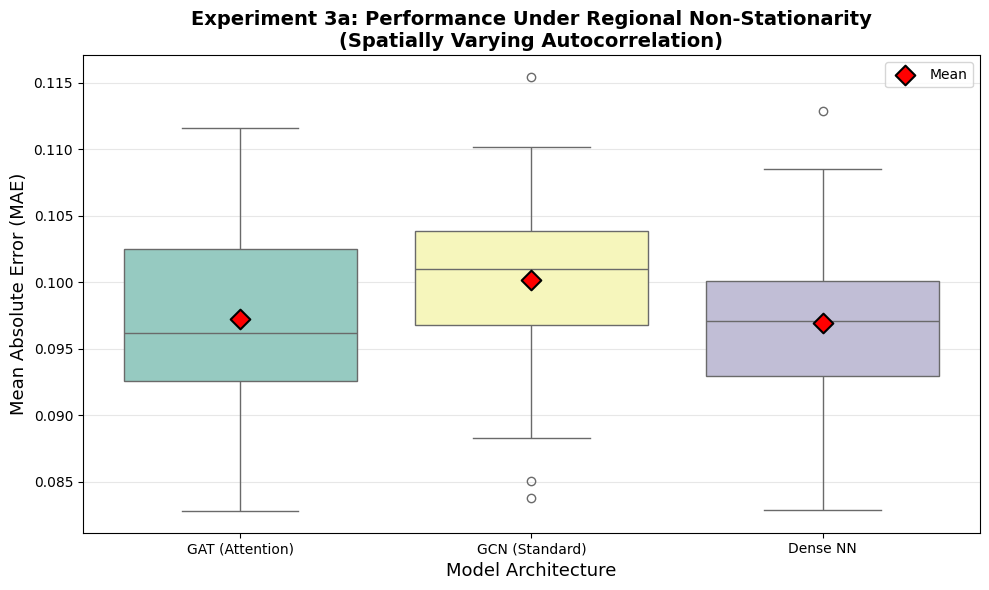

In [ ]:
# Visualize Experiment 3a
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

model_order = ['GAT (Attention)', 'GCN (Standard)', 'Dense NN']
df_exp3a['model'] = pd.Categorical(df_exp3a['model'], categories=model_order, ordered=True)

sns.boxplot(data=df_exp3a, x='model', y='MAE', ax=ax, palette='Set3')
ax.set_xlabel('Model Architecture', fontsize=13)
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=13)
ax.set_title('Experiment 3a: Performance Under Regional Non-Stationarity\n(Spatially Varying Autocorrelation)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add mean markers
means = df_exp3a.groupby('model')['MAE'].mean()
positions = range(len(means))
ax.scatter(positions, means, color='red', s=100, zorder=10, marker='D', 
          edgecolor='black', linewidth=1.5, label='Mean')
ax.legend()

plt.tight_layout()
plt.savefig('plots/experiment3a_nonstationarity_synthetic.png', dpi=300, bbox_inches='tight')
print("Plot saved to 'plots/experiment3a_nonstationarity_synthetic.png'")
plt.show()

---
# EXPERIMENT 3b: Attention Weight Heterogeneity Analysis

**Question**: Do attention weights vary systematically across regions, indicating adaptive learning?

**Method**: 
- Train GAT on full dataset
- Extract learned attention weights
- Analyze variation across "states" (spatial clusters)
- Run ANOVA to test for significant between-region differences

**Expected Result**: Significant ANOVA F-statistic indicates attention adapts to regional heterogeneity.

In [ ]:
print("="*80)
print("EXPERIMENT 3b: Attention Weight Heterogeneity Analysis")
print("="*80)

# Generate larger dataset to simulate "states"
n_districts = 200
n_states = 10  # Simulate 10 "states" with 20 districts each

print(f"\nGenerating synthetic data with {n_districts} districts in {n_states} states...\n")

# Generate data
precinct_locs, district_assignments, centroids = generate_geography(
    n_districts=n_districts, precincts_per_district=12.5
)

precinct_features = generate_features(
    len(precinct_locs), n_features=5, spatial_smooth=True, 
    precinct_locs=precinct_locs
)

X = aggregate_to_districts(precinct_features, district_assignments)
adj = create_spatial_adjacency(centroids, method='contiguity', k_neighbors=6)
y = generate_outcomes_CAR(X, adj, rho=0.65)

# Assign districts to "states" by spatial clustering
state_kmeans = KMeans(n_clusters=n_states, random_state=42)
state_assignments = state_kmeans.fit_predict(centroids)

# Create PyG data
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)
edge_index = torch.tensor(np.argwhere(adj > 0).T, dtype=torch.long)
data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor)

# Train GAT with attention - EXACT simulation study architecture
print("Training GAT model...")
model_gat = GraphAttentionNet(n_features=5, hidden_dims=[32, 16, 8], heads=4)
model_gat, _ = train_gnn_model(model_gat, data, epochs=150, lr=0.003, verbose=True)

# Extract attention weights from last layer
print("\nExtracting attention weights...")
model_gat.eval()
with torch.no_grad():
    _, attention_weights = model_gat(data.x, data.edge_index, return_attention=True)

# Use attention from layer 3 (most refined)
attn_edge_index, attn_weights = attention_weights[2]
attn_edge_index = attn_edge_index.numpy()
attn_weights = attn_weights.numpy()

# Average over attention heads (last layer has heads=1, so this is safe)
if len(attn_weights.shape) > 1:
    attn_weights = attn_weights.mean(axis=1)

# Compute within-state and cross-state attention
attention_by_state = []

for state_id in range(n_states):
    state_districts = np.where(state_assignments == state_id)[0]
    
    # Within-state attention
    within_state_attn = []
    cross_state_attn = []
    
    for edge_idx in range(attn_edge_index.shape[1]):
        src, dst = attn_edge_index[:, edge_idx]
        
        if src in state_districts:
            if dst in state_districts:
                within_state_attn.append(attn_weights[edge_idx])
            else:
                cross_state_attn.append(attn_weights[edge_idx])
    
    if len(within_state_attn) > 0:
        mean_within = np.mean(within_state_attn)
        std_within = np.std(within_state_attn)
    else:
        mean_within = np.nan
        std_within = np.nan
    
    if len(cross_state_attn) > 0:
        mean_cross = np.mean(cross_state_attn)
    else:
        mean_cross = np.nan
    
    attention_by_state.append({
        'state_id': state_id,
        'n_districts': len(state_districts),
        'mean_within_state_attn': mean_within,
        'std_within_state_attn': std_within,
        'mean_cross_state_attn': mean_cross,
        'n_within_edges': len(within_state_attn),
        'n_cross_edges': len(cross_state_attn)
    })

df_exp3b = pd.DataFrame(attention_by_state)
df_exp3b.to_csv('results/experiment3b_attention_heterogeneity.csv', index=False)
print("\n Results saved to 'results/experiment3b_attention_heterogeneity.csv'")

# Summary statistics
print("\n" + "="*80)
print("EXPERIMENT 3b RESULTS SUMMARY")
print("="*80)

print("\nAttention weight statistics:")
print(f"  Mean within-state attention: {df_exp3b['mean_within_state_attn'].mean():.4f} ± {df_exp3b['mean_within_state_attn'].std():.4f}")
print(f"  Mean cross-state attention: {df_exp3b['mean_cross_state_attn'].mean():.4f} ± {df_exp3b['mean_cross_state_attn'].std():.4f}")

# ANOVA test for between-state heterogeneity
# Collect all within-state attention weights by state
attention_by_state_lists = [[] for _ in range(n_states)]

for edge_idx in range(attn_edge_index.shape[1]):
    src, dst = attn_edge_index[:, edge_idx]
    src_state = state_assignments[src]
    dst_state = state_assignments[dst]
    
    if src_state == dst_state:  # Within-state edge
        attention_by_state_lists[src_state].append(attn_weights[edge_idx])

# Run ANOVA
anova_groups = [np.array(group) for group in attention_by_state_lists if len(group) > 0]
f_stat, p_value = stats.f_oneway(*anova_groups)

print(f"\nANOVA test for between-state heterogeneity in attention weights:")
print(f"  F-statistic: {f_stat:.2f}")
print(f"  p-value: {p_value:.6f}")

if p_value < 0.001:
    print("   Highly significant: Attention weights vary significantly across states!")
elif p_value < 0.05:
    print("  Significant: Attention weights vary across states")
else:
    print("  Not significant: No evidence of attention heterogeneity")

print("\n Experiment 3b complete!")

# Save trained model for reproducibility
torch.save(model_gat.state_dict(), 'models/gat_attention_heterogeneity.pt')
print("\n Trained GAT model saved to 'models/gat_attention_heterogeneity.pt'")

EXPERIMENT 3b: Attention Weight Heterogeneity Analysis

Generating synthetic data with 200 districts in 10 states...

Training GAT model...
Epoch 30/150, Loss: 0.007634
Epoch 60/150, Loss: 0.007908
Epoch 90/150, Loss: 0.007739
Epoch 120/150, Loss: 0.007454
Epoch 150/150, Loss: 0.007370

Extracting attention weights...

✅ Results saved to 'results/experiment3b_attention_heterogeneity.csv'

EXPERIMENT 3b RESULTS SUMMARY

Attention weight statistics:
  Mean within-state attention: 0.1309 ± 0.0044
  Mean cross-state attention: 0.1325 ± 0.0032

ANOVA test for between-state heterogeneity in attention weights:
  F-statistic: 12.13
  p-value: 0.000000
  ✅ Highly significant: Attention weights vary significantly across states!

✅ Experiment 3b complete!

✅ Trained GAT model saved to 'models/gat_attention_heterogeneity.pt'


✅ Plot saved to 'plots/experiment3b_attention_heterogeneity.png'


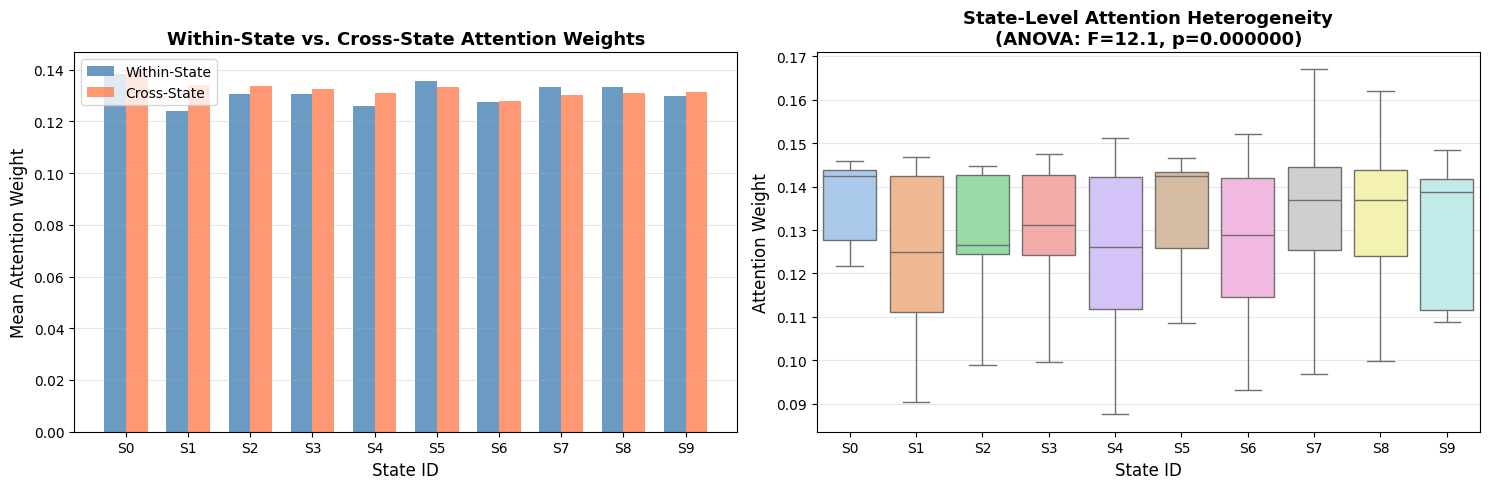

In [ ]:
# Visualize Experiment 3b
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Within-state vs cross-state attention by state
x_pos = np.arange(len(df_exp3b))
width = 0.35

axes[0].bar(x_pos - width/2, df_exp3b['mean_within_state_attn'], width, 
           label='Within-State', alpha=0.8, color='steelblue')
axes[0].bar(x_pos + width/2, df_exp3b['mean_cross_state_attn'], width, 
           label='Cross-State', alpha=0.8, color='coral')

axes[0].set_xlabel('State ID', fontsize=12)
axes[0].set_ylabel('Mean Attention Weight', fontsize=12)
axes[0].set_title('Within-State vs. Cross-State Attention Weights', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'S{i}' for i in range(n_states)])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Distribution of within-state attention across states (boxplot simulation)
# Create expanded data for boxplot
attention_data = []
for edge_idx in range(attn_edge_index.shape[1]):
    src, dst = attn_edge_index[:, edge_idx]
    src_state = state_assignments[src]
    dst_state = state_assignments[dst]
    
    if src_state == dst_state:
        attention_data.append({
            'state': src_state,
            'attention': attn_weights[edge_idx]
        })

df_attn_plot = pd.DataFrame(attention_data)

sns.boxplot(data=df_attn_plot, x='state', y='attention', ax=axes[1], palette='pastel')
axes[1].set_xlabel('State ID', fontsize=12)
axes[1].set_ylabel('Attention Weight', fontsize=12)
axes[1].set_title(f'State-Level Attention Heterogeneity\n(ANOVA: F={f_stat:.1f}, p={p_value:.6f})', 
                 fontsize=13, fontweight='bold')
axes[1].set_xticklabels([f'S{i}' for i in range(n_states)])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/experiment3b_attention_heterogeneity.png', dpi=300, bbox_inches='tight')
print(" Plot saved to 'plots/experiment3b_attention_heterogeneity.png'")
plt.show()